In [1]:
import gcsfs #module for google cloud connection
import os
import allel
import zarr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import pyfasta
import matplotlib

In [2]:
gcs_orig = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache')
#gcs =  gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token=gcs_orig.session.credentials)

In [3]:
gcs =  gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cloud')

In [4]:
 ###### Adding phase2 haplotype path ######
    
phase2happath = os.path.join("ag1000g-release", "phase2.AR1", "haplotypes", "main", "zarr", "ag1000g.phase2.ar1.haplotypes")
gcsmap3 = gcsfs.mapping.GCSMap(phase2happath, gcs=gcs)
calldata_hap_phase2= zarr.Group(gcsmap3, read_only=True)

In [5]:
accessibility_path = os.path.join("ag1000g-release", "phase2.AR1", "accessibility", "accessibility.zarr")
gcsacmap = gcsfs.mapping.GCSMap(accessibility_path, gcs=gcs)
accessibility= zarr.Group(gcsacmap, read_only=True)

In [8]:
###### loading phase2 metadata ######
metadata = pd.read_csv("samples.meta.txt", sep="\t")
pop_select = metadata.population.isin({'BFgam', 'BFcol'}).values
pop_subset = metadata[pop_select]

In [9]:
genotypes_phase2_call = calldata_hap_phase2['3R']["calldata/GT"]
genotypes_phase2 = allel.GenotypeChunkedArray(genotypes_phase2_call)
geno_p2_subset = genotypes_phase2.subset(sel1=pop_select)

In [10]:
grp = pop_subset.groupby("population")
grp_indices = grp.indices
ac_subpops = geno_p2_subset.count_alleles_subpops(grp_indices)

In [11]:
ac_subpops

<AlleleCountsChunkedTable shape=(10752701,) dtype=[('BFcol', '<i4', (2,)), ('BFgam', '<i4', (2,))]
   nbytes=164.1M cbytes=20.7M cratio=7.9
   values=allel.chunked.storage_zarr.ZarrTable>

In [12]:
pos = calldata_hap_phase2['3R']['variants']['POS'][:]    
pos.shape

(10752701,)

In [13]:
pos = allel.SortedIndex(pos, copy=False)
pos

0,1,2,3,4,...,10752696,10752697,10752698,10752699,10752700
9526,9531,9544,9546,9549,...,53195257,53195262,53195269,53195273,53195279


In [13]:
pos.max()

53195279

In [21]:
is_accessible = accessibility['3R']['is_accessible'][:]

In [18]:
dxy, windows, n_bases, counts = allel.windowed_divergence(pos, ac_subpops['BFgam'], ac_subpops['BFcol'], 
                                                                    size=50000, 
                                                                    start=1, 
                                                                    stop=pos.max(),
                                                                    is_accessible=is_accessible
                                                             )

(0, 0.018)

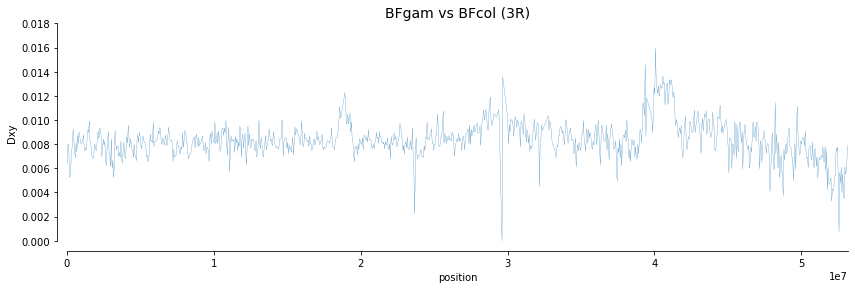

In [19]:
min_n_bases=1
x = np.mean(windows[n_bases >= min_n_bases], axis=1)
y = dxy[n_bases >= min_n_bases]
fig, ax = plt.subplots(figsize=(14, 4))
sns.despine(ax=ax, offset=10)
ax.plot(x, y, lw=.25)
ax.set_xlim(0, pos.max())
ax.set_title('%s vs %s (%s)' % ('BFgam', 'BFcol', '3R'), fontsize=14)
ax.set_ylabel('Dxy')
ax.set_xlabel('position')
ax.set_ylim(0,0.018)

-------------------------------

## Create the Dxy function

In [17]:
def plot_dxy(pop1, pop2, chrom, window_size=20000, min_n_bases=1):
    metadata = pd.read_csv("samples.meta.txt", sep="\t")
    pop_select = metadata.population.isin({pop1,pop2}).values
    pop_subset = metadata[pop_select]
    genotypes_phase2_call = calldata_hap_phase2[chrom]["calldata/GT"]
    genotypes_phase2 = allel.GenotypeChunkedArray(genotypes_phase2_call)
    geno_p2_subset = genotypes_phase2.subset(sel1=pop_select)
    grp = pop_subset.groupby("population")
    grp_indices = grp.indices
    ac_subpops = geno_p2_subset.count_alleles_subpops(grp_indices)
    ac1 = ac_subpops[pop1]
    ac2 = ac_subpops[pop2]
    pos = calldata_hap_phase2[chrom]['variants']['POS'][:] 
    is_accessible = accessibility[chrom]['is_accessible'][:]
    dxy, windows, n_bases, counts = allel.windowed_divergence(pos, ac1, ac2, 
                                                                    size=window_size, 
                                                                    start=1, 
                                                                    stop=pos.max(),
                                                                    is_accessible=is_accessible
                                                             )
    x = np.mean(windows[n_bases >= min_n_bases], axis=1)
    y = dxy[n_bases >= min_n_bases]
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.despine(ax=ax, offset=10)
    ax.plot(x, y, lw=.5)
    ax.set_xlim(0, pos.max())
    ax.set_title('%s vs %s (%s)' % (pop1, pop2, chrom), fontsize=14)
    ax.set_ylabel('Dxy')
    ax.set_xlabel('position')
    ax.set_ylim(0,0.018)    

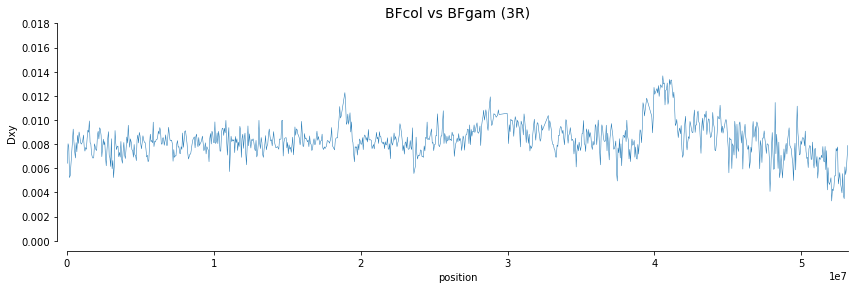

In [18]:
plot_dxy('BFcol', 'BFgam', '3R',  window_size=50000, min_n_bases=1000)

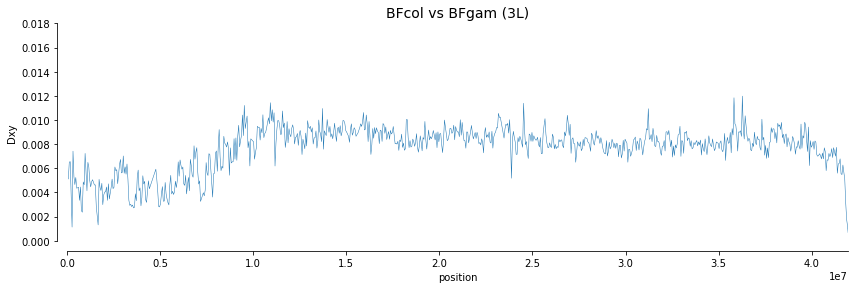

In [19]:
plot_dxy('BFcol', 'BFgam', '3L',  window_size=50000, min_n_bases=1000)

-----------------------------------------------

## Pi between BFgam and BFcol

In [32]:
pi, windows, n_bases, counts = allel.windowed_diversity(pos, ac_subpops['BFgam'], size=50000, start=1, stop=pos.max(), is_accessible=is_accessible)

(0, 0.018)

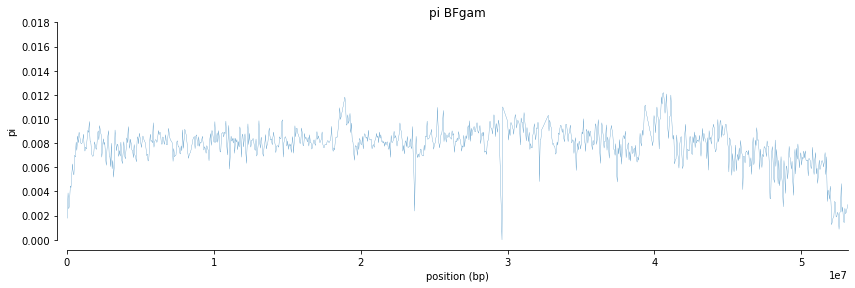

In [35]:
min_n_bases=1
x = np.mean(windows[n_bases >= min_n_bases], axis=1)
y = pi[n_bases >= min_n_bases]
fig, ax = plt.subplots(figsize=(14, 4))
sns.despine(ax=ax, offset=10)
ax.plot(x, y, lw=.25)
ax.set_xlim(0, pos.max())
ax.set_title('pi BFgam')
ax.set_ylabel('pi')
ax.set_xlabel('position (bp)')
ax.set_ylim(0,0.018)

In [36]:
pi, windows, n_bases, counts = allel.windowed_diversity(pos, ac_subpops['BFcol'], size=50000, start=1, stop=pos.max(), is_accessible=is_accessible)

(0, 0.018)

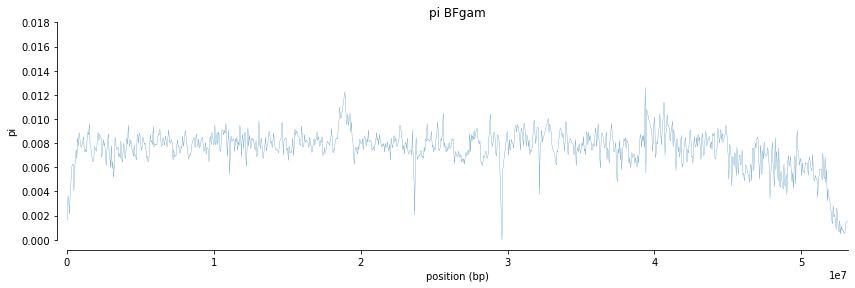

In [37]:
min_n_bases=1
x = np.mean(windows[n_bases >= min_n_bases], axis=1)
y = pi[n_bases >= min_n_bases]
fig, ax = plt.subplots(figsize=(14, 4))
sns.despine(ax=ax, offset=10)
ax.plot(x, y, lw=.25)
ax.set_xlim(0, pos.max())
ax.set_title('pi BFgam')
ax.set_ylabel('pi')
ax.set_xlabel('position (bp)')
ax.set_ylim(0,0.018)

---------------------------------------------------

<b>Gmin</b> minimum divergence between one sequence from X and one from Y (minDivXY) divided by the average divXY

In [14]:
(np.count_nonzero( dxy == 0))

28

In [26]:
len(dxy)

1064

In [27]:
a = 28/1064

In [17]:
allel.pairwise_dxy(pos, ac_subpops['BFgam'], ac_subpops['BFcol'])

TypeError: bad number of dimensions: expected 3; found 2

In [21]:
min_dxy = 28/1064

In [22]:
min_dxy

0.02631578947368421

In [14]:
windows = allel.moving_statistic(pos, statistic=lambda v: [v[0], v[-1]], size=50000)
x = np.asarray(windows).mean(axis=1)

In [21]:
len(x), len(g_min)

(215, 1064)

In [ ]:
10752700/1064

In [32]:
a = allel.sequence_divergence(pos, ac_subpops['BFgam'], ac_subpops['BFcol'])
a

0.00506614930070903

In [18]:
b = allel.mean_pairwise_difference_between(ac_subpops['BFgam'], ac_subpops['BFcol'])
b

array([0.        , 0.        , 0.        , ..., 0.        , 0.02173913,
       0.03333333])

In [19]:
len(b)

10752701

In [30]:
g_min = a/b

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [31]:
g_min

array([       inf,        inf,        inf, ...,        inf, 1.21052632,
       0.78947368])

In [28]:
g_min = dxy.min()/b
g_min

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([nan, nan, nan, ..., nan,  0.,  0.])

In [19]:
len(counts)

1064

In [23]:
len(g_min)

10752701

In [32]:
y = g_min
fig, ax = plt.subplots(figsize=(14, 4))
sns.despine(ax=ax, offset=10)
ax.plot(pos, y, lw=.25)
ax.set_xlim(0, pos.max())
ax.set_title('%s vs %s (%s)' % ('BFgam', 'BFcol', '3R'), fontsize=14)
ax.set_ylabel('Dxy')
ax.set_xlabel('position')
#ax.set_ylim(0,0.018)

Text(0.5, 0, 'position')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f1dab8f2840> (for post_execute):


OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)

OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)

<Figure size 1008x288 with 1 Axes>

In [14]:
ac_subpops['BFgam'], ac_subpops['BFcol']

(<AlleleCountsChunkedArray shape=(10178803, 2) dtype=int32 chunks=(159044, 2)
    nbytes=77.7M cbytes=11.1M cratio=7.0
    compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
    values=zarr.core.Array>,
 <AlleleCountsChunkedArray shape=(10178803, 2) dtype=int32 chunks=(159044, 2)
    nbytes=77.7M cbytes=10.5M cratio=7.4
    compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
    values=zarr.core.Array>)

In [ ]:
pairwiseSum = [] #total of pairwise Pis
totalPairs = 0 #haplotype pairs considered    

for i in ac_subpops['BFgam']: # for each sequence in pop1...
      for j in ac_subpops['BFcol']: #for sequence in pop2...
        seqA = ac_subpops['BFgam'][0]
        seqB = ac_subpops['BFcol'][0]
        zippedSeqs = zip(seqA,seqB)
        diffs = sum(sA != sB for sA, sB in zippedSeqs if sA != "N" and sB != "N")
        #sites = sum(sA != "N" and sB != "N" for sA, sB in zippedSeqs)
        sites = len([site for site in zippedSeqs if site[0] != "N" and site[1] != "N"])
        #now add this pairwise dxy to the total and add 1 to the number of pairs considered
        pairwiseSum.append(1.0*diffs/sites)
        totalPairs += 1     
        
        # modified to return dxy, gmin and gmax
        output = {}
        dxy_val = sum(pairwiseSum)/totalPairs
        dmin = min(pairwiseSum)
        gmin_val = dmin/dxy_val
        gmax_val = max(pairwiseSum)/dxy_val
        output["dxy"] = dxy_val
        output["dmin"] = dmin
        output["gmin"] = gmin_val
        output["gmax"] = gmax_val

return output

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


--------------------------------------

## Sandbox

In [18]:
fasta_fn = 'Anopheles-gambiae-PEST_CHROMOSOMES_AgamP3.fa'
genome = pyfasta.Fasta(fasta_fn, key_fn=lambda k: k.split()[0])

In [19]:
seq = np.asarray(genome['3L'])

In [28]:
seq.size, pos.max()

(41963435, 53195279)

(0, 0.018)

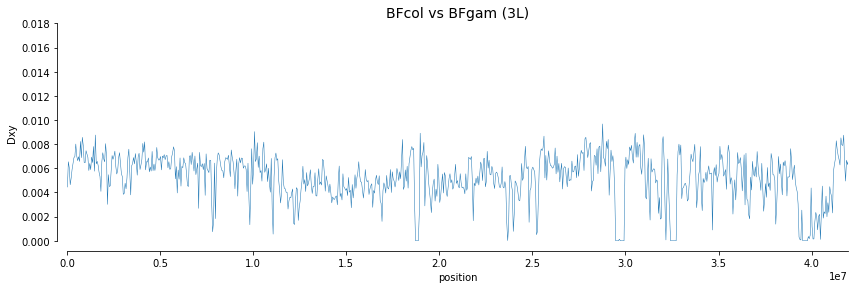

In [29]:
dxy, windows, n_bases, counts = allel.windowed_divergence(pos, ac_subpops['BFcol'], ac_subpops['BFgam'], 
                                                                    size=50000, 
                                                                    start=1, 
                                                                    stop=seq.size
                                                             )
min_n_bases=1
x = np.mean(windows[n_bases >= min_n_bases], axis=1)
y = dxy[n_bases >= min_n_bases]
fig, ax = plt.subplots(figsize=(14, 4))
sns.despine(ax=ax, offset=10)
ax.plot(x, y, lw=.5)
ax.set_xlim(0, seq.size)
ax.set_title('%s vs %s (%s)' % ('BFcol', 'BFgam', '3L'), fontsize=14)
ax.set_ylabel('Dxy')
ax.set_xlabel('position')
ax.set_ylim(0,0.018)

(0, 0.018)

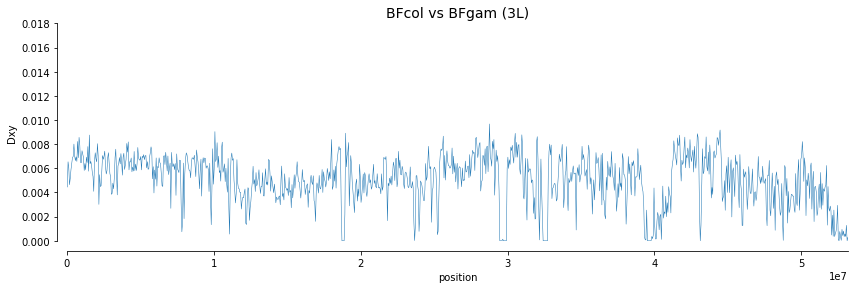

In [25]:
dxy, windows, n_bases, counts = allel.windowed_divergence(pos, ac_subpops['BFcol'], ac_subpops['BFgam'], 
                                                                    size=50000, 
                                                                    start=1, 
                                                                    stop=pos.max()
                                                             )
min_n_bases=1
x = np.mean(windows[n_bases >= min_n_bases], axis=1)
y = dxy[n_bases >= min_n_bases]
fig, ax = plt.subplots(figsize=(14, 4))
sns.despine(ax=ax, offset=10)
ax.plot(x, y, lw=.5)
ax.set_xlim(0, pos.max())
ax.set_title('%s vs %s (%s)' % ('BFcol', 'BFgam', '3L'), fontsize=14)
ax.set_ylabel('Dxy')
ax.set_xlabel('position')
ax.set_ylim(0,0.018)